In [1]:
from IPython.display import display

from hurst_exponent.util.utils import augmented_dickey_fuller

from notebooks.util.long_memory_utils import *
from liquidity.response_functions.features import add_aggregate_features

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 100

## Load limit orders raw sample data

In [24]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1-LO.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [18]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,side,lob_action,price,size,old_size,best_ask_price,best_ask_size,best_bid_price,best_bid_size,is_new_best_price,is_new_best_size,price_level,old_price_level,midprice,sign,midprice_change,R1_LO,norm_size
0,43258,2016-01-05 10:30:00.384537982,ASK,INSERT,222.61,100,0,222.94,100.0,222.38,200.0,True,False,1,0,222.660,1,-0.165,-0.165,0.990383
1,43262,2016-01-05 10:30:00.833252732,BID,INSERT,222.49,100,0,222.61,100.0,222.38,100.0,True,False,1,0,222.495,-1,0.055,-0.055,1.036284
2,43267,2016-01-05 10:30:00.835711088,BID,INSERT,222.49,100,0,222.61,100.0,222.49,100.0,False,True,1,1,222.550,-1,0.000,-0.000,1.036284
3,43271,2016-01-05 10:30:00.889596297,BID,INSERT,222.50,100,0,222.61,100.0,222.49,200.0,True,True,1,0,222.550,-1,0.210,-0.210,1.036284
4,43276,2016-01-05 10:30:01.171678818,BID,INSERT,222.51,100,0,223.02,100.0,222.50,100.0,True,False,1,0,222.760,-1,0.005,-0.005,1.036284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539714,224203,2016-12-29 14:59:39.927858544,ASK,INSERT,214.81,100,0,214.82,100.0,214.72,100.0,True,False,1,0,214.770,1,-0.005,-0.005,0.990383
2539715,224205,2016-12-29 14:59:39.929190848,ASK,INSERT,214.80,100,0,214.81,100.0,214.72,100.0,True,False,1,0,214.765,1,-0.005,-0.005,0.990383
2539716,224210,2016-12-29 14:59:39.931024014,ASK,INSERT,214.80,159,0,214.80,100.0,214.72,100.0,False,True,1,1,214.760,1,0.000,0.000,1.574709
2539717,224211,2016-12-29 14:59:39.994907085,ASK,INSERT,214.80,1,0,214.80,259.0,214.72,100.0,False,True,1,1,214.760,1,-0.025,-0.025,0.009904


# The Long Memory of Orderflow (Trades)

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Signed Orderflow

In [20]:
# Signs
signed_orderflow = {
  'TSLA': tsla_raw_df['sign'],
  'MSFT': msft_raw_df['sign'],
  'AMZN': amzn_raw_df['sign'],
  'NFLX': nflx_raw_df['sign'],
  'EBAY': ebay_raw_df['sign'],
  'APPL': appl_raw_df['sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [21]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -32.77
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -75.87
p-value: 0.00,
N: 499944, 
critical values: {'1%': -3.4303630801321265, '5%': -2.86154578126444, '10%': -2.5667730771558785}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -26.54
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -44.15
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


E

### 1.1. Signs ACF

In [25]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/lo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [26]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/lo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


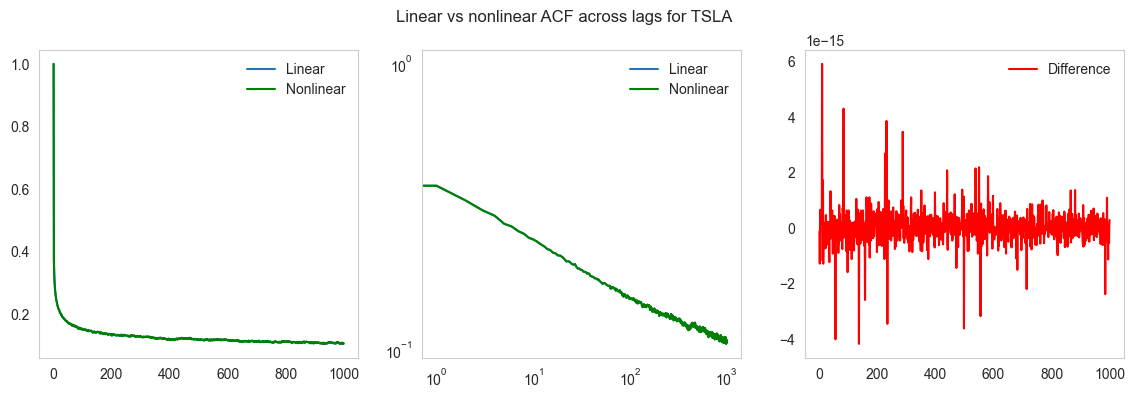

TSLA Max difference: 5.9119376061289586e-15


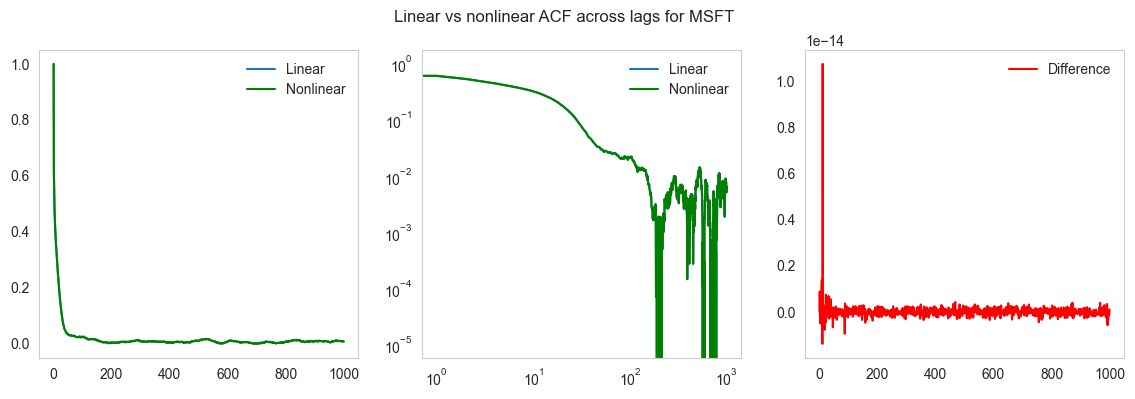

MSFT Max difference: 1.0769163338864018e-14


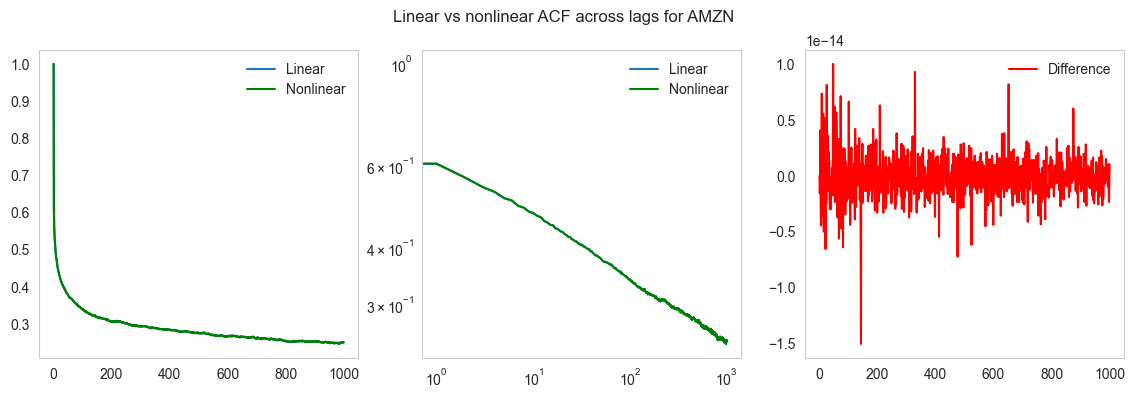

AMZN Max difference: 1.0047518372857667e-14


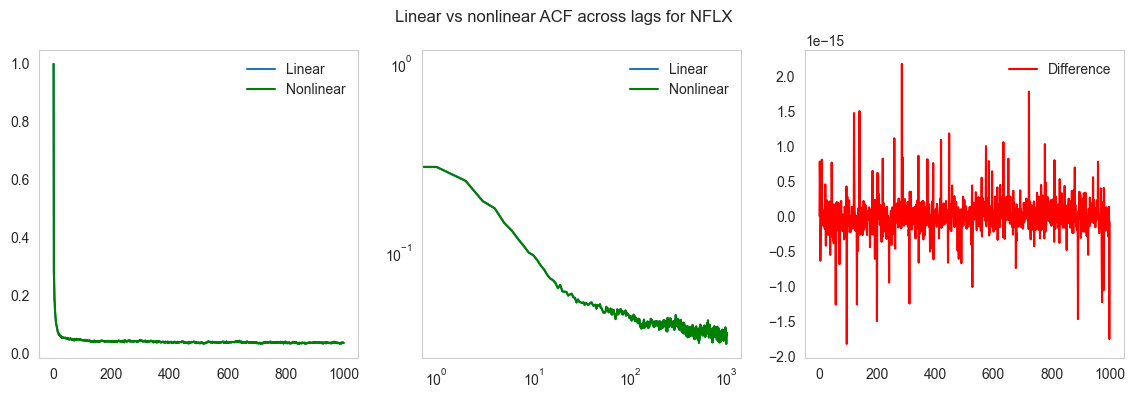

NFLX Max difference: 2.1718737919229625e-15


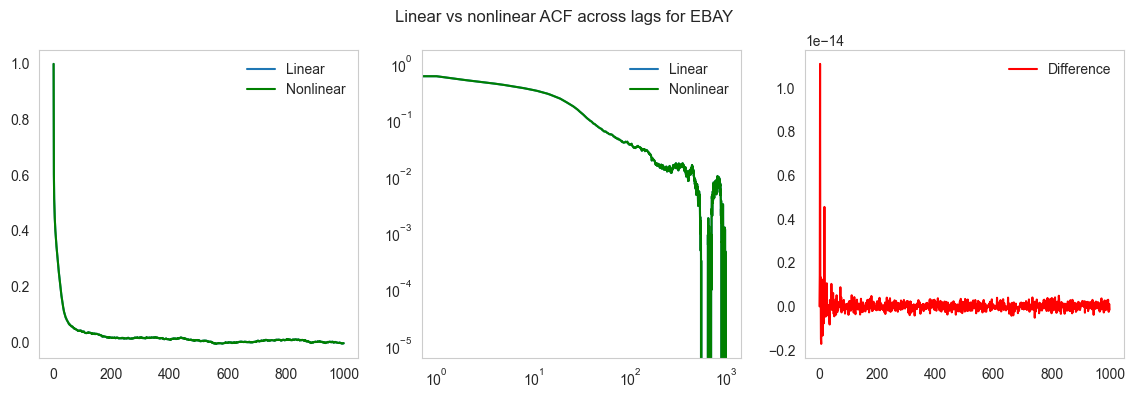

EBAY Max difference: 1.1102230246251565e-14


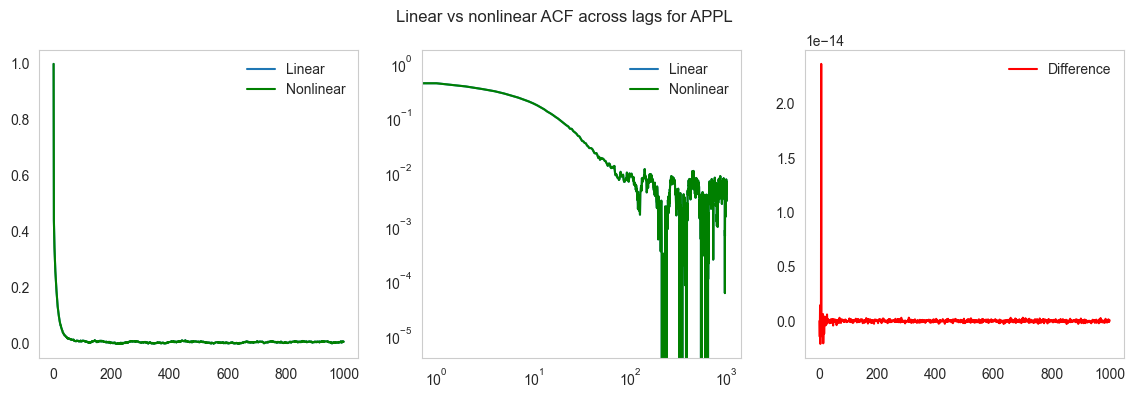

APPL Max difference: 2.3647750424515834e-14


In [27]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 1.2. Fit power law to ACF

In [28]:
# Load the pre-computed ACFs
signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [29]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.3071692...",52,53.0,0.037935,-12077.728016,1.094347,0.984870,-0.153009,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.8390494...",7,8.0,0.224346,-9672.984801,219.995958,0.952876,-1.217931,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.6550915...",2,3.0,0.038038,-12201.002474,0.562230,0.997421,-0.140083,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0838876...",13,14.0,0.067814,-12049.692255,3.933743,0.806927,-0.124104,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 7.3154175...",16,17.0,0.303553,-10508.327318,300.712944,0.974359,-1.149177,EBAY


In [30]:
signs_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [31]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6371189063433529


### 1.3. Signed Orderflow Hurst Exponents

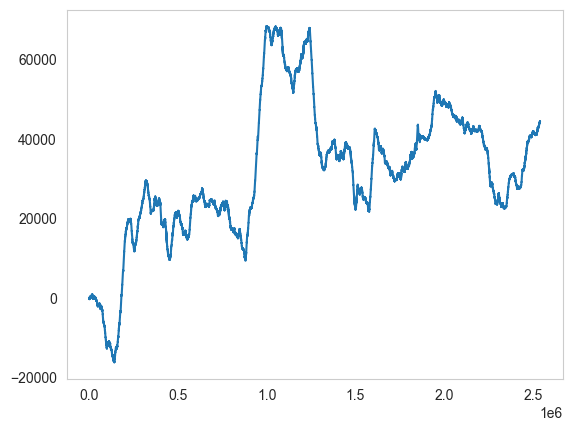

In [33]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['sign'].cumsum(),
  'MSFT': msft_raw_df['sign'].cumsum(),
  'AMZN': amzn_raw_df['sign'].cumsum(),
  'NFLX': nflx_raw_df['sign'].cumsum(),
  'EBAY': ebay_raw_df['sign'].cumsum(),
  'APPL': appl_raw_df['sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [34]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8086792...",178,12.0,0.012014,-9648.890300,0.151408,0.999991,0.870703,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8351050...",1103,52.0,0.021236,-4794.757337,0.197312,0.999719,0.731569,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8880037...",36,4.0,0.010879,-8497.478233,0.087657,0.999998,0.902829,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1392813...",366,12.0,0.011672,-21031.890483,0.152891,0.999980,0.693459,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8101624...",696,50.0,0.021157,-3227.407908,0.204564,0.999719,0.731942,EBAY,signs
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7806066...",459,34.0,0.015301,-4568.402870,0.274442,0.999724,0.641834,APPL,signs


In [35]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7620559369148913


#### Generalized Hurst

In [36]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7291192...",146,10.0,0.011748,-9678.075802,0.212410,0.999984,0.843009,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.1247634...",1254,59.0,0.024859,-4648.087201,0.161439,0.999661,0.665456,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.8467565...",13,2.0,0.010657,-7850.407734,0.220232,0.999994,0.869423,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9972698...",200,7.0,0.011043,-20873.033131,0.275579,0.999958,0.673248,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.1065986...",824,59.0,0.025818,-3006.996469,0.168699,0.999629,0.665100,EBAY,signs


In [37]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6025038751087508
Max Generalized Hurst: 0.8694234116085623
Average Generalized Hurst: 0.7197900544856107
Standard_dev Generalized Hurst: 0.10903074469208593


## 2. Size/ Volume

In [39]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_size'],
               'MSFT': amzn_raw_df['norm_size'],
               'AMZN': nflx_raw_df['norm_size'],
               'NFLX': msft_raw_df['norm_size'],
               'EBAY': ebay_raw_df['norm_size'],
               'APPL': appl_raw_df['norm_size'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [40]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -42.38
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -26.70
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -127.06
p-value: 0.00,
N: 499972, 
critical values: {'1%': -3.4303630793995947, '5%': -2.8615457809406704, '10%': -2.5667730769835475}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -42.59
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 2.1. Size/volume ACF

In [41]:
# Linear ACF
volume_linear_acf_filename = f"{acf_data_dir}/lo_volume_linear_acfs.pkl"
volume_linear_acfs = compute_acfs(filename=volume_linear_acf_filename, data=size_volume, option='linear')
print(volume_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [42]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/lo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=size_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


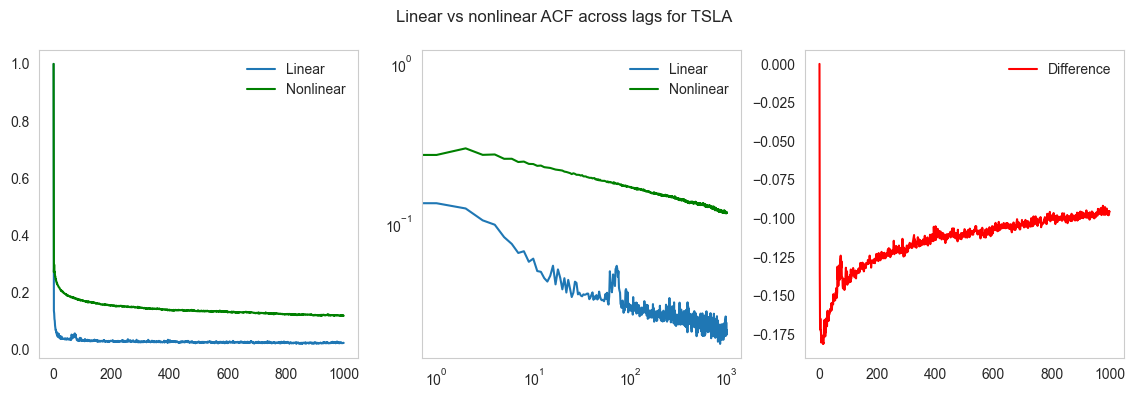

TSLA Max difference: 0.0


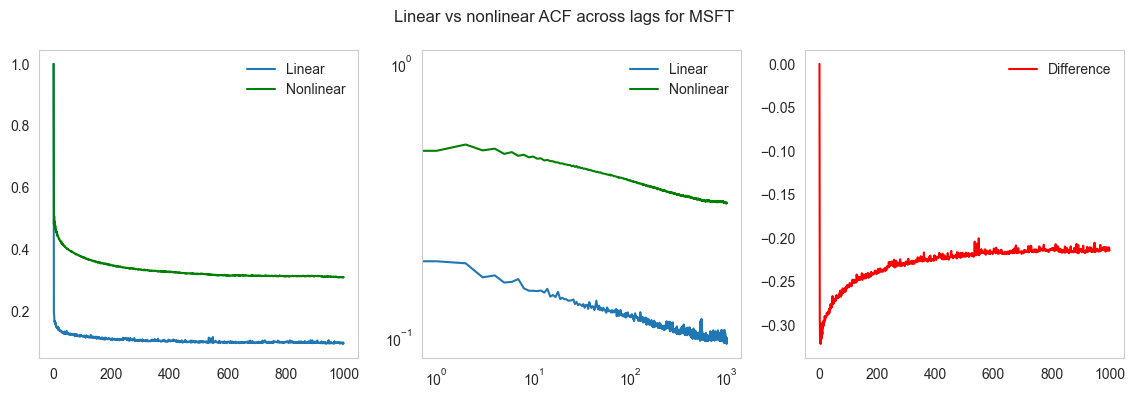

MSFT Max difference: 0.0


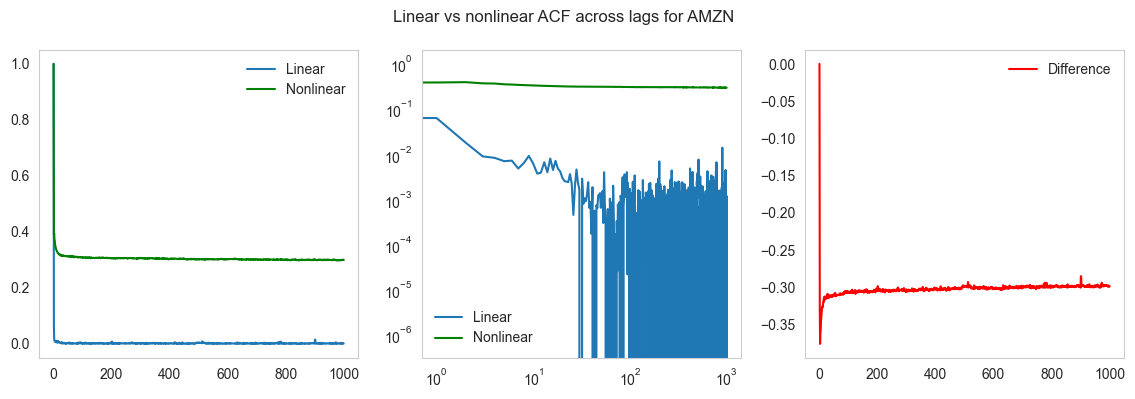

AMZN Max difference: 0.0


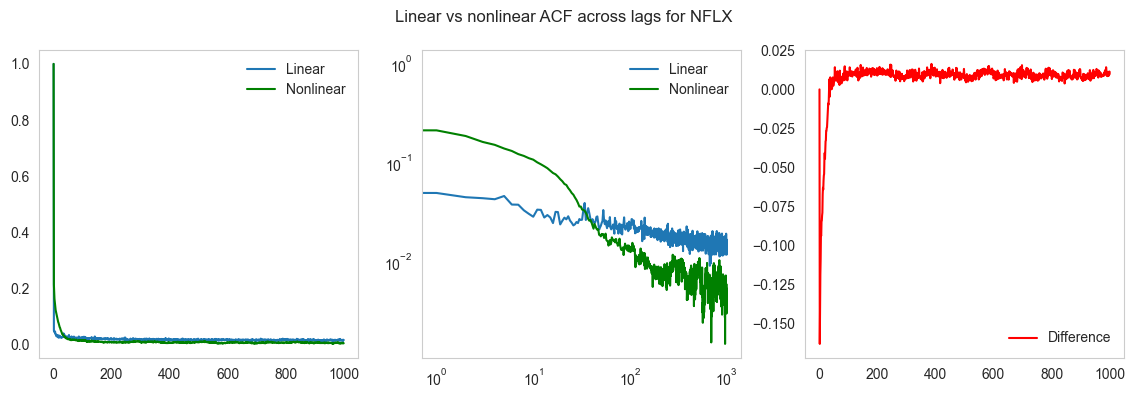

NFLX Max difference: 0.016350795993074468


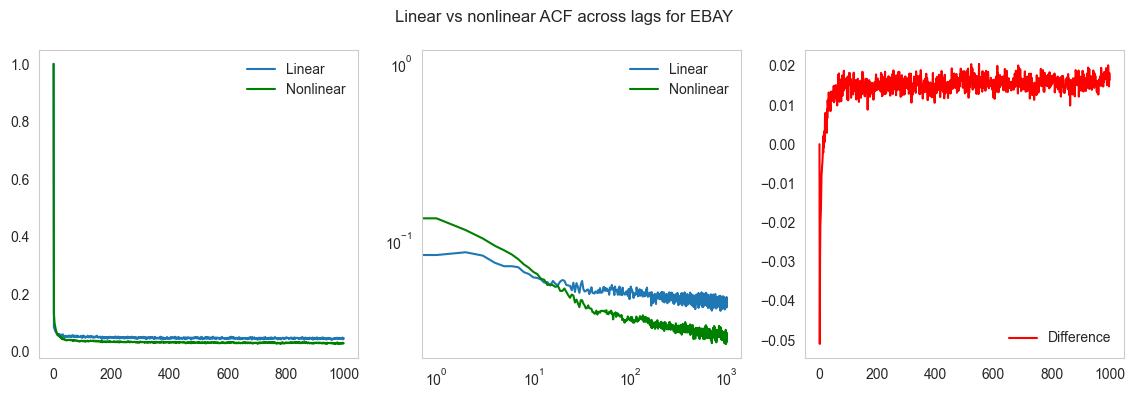

EBAY Max difference: 0.02049646243587147


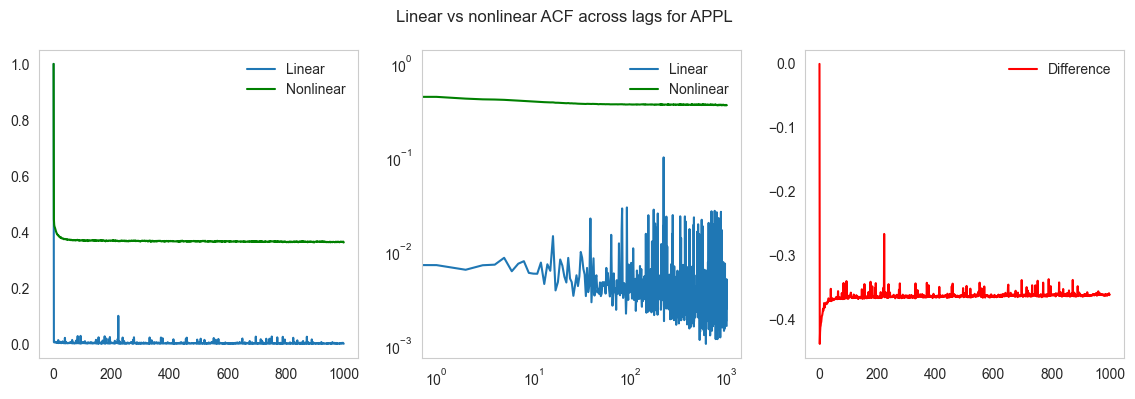

APPL Max difference: -1.1102230246251565e-16


In [43]:
for stock_name in volume_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_linear_acfs, volume_nonlinear_acfs)

### 2.2. Fit power law to ACF

In [44]:
# Load the pre-computed ACFs
volume_acf_values = {}

for stock, data in volume_nonlinear_acfs.items():
    volume_acf_values[stock] = construct_xy(data, stock)

In [45]:
# Using volume_nonlinear_acfs
volume_fit_results_list = []
volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[stock] = fit_obj  # Store the fit object

volume_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5148089...",539,540.0,0.041126,-6322.372387,0.676608,0.953030,-0.214725,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.6062417...",857,858.0,0.083333,-2076.351493,0.178534,0.784165,-0.096683,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.3330699...",8,9.0,0.063444,-13019.929828,0.279587,0.905254,-0.015892,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1094288...",34,35.0,0.118925,-12261.131720,20.059148,0.753893,-0.453234,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0639372...",18,19.0,0.075280,-12894.419395,3.156177,0.843462,-0.115973,EBAY


In [46]:
volume_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [47]:
avg_alpha = volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.15077893458152108


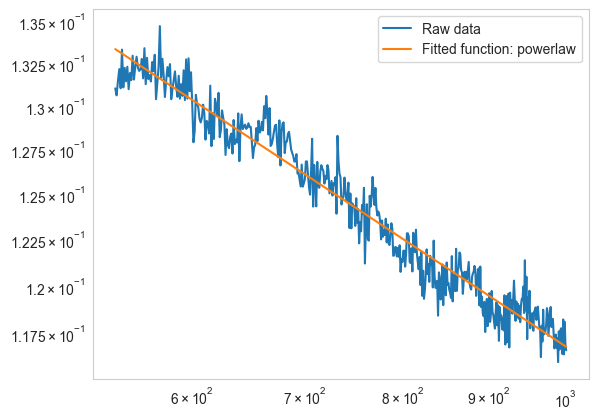

In [48]:
tsla_acf_fit = volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3. Size/ Volume Hurst Exponents

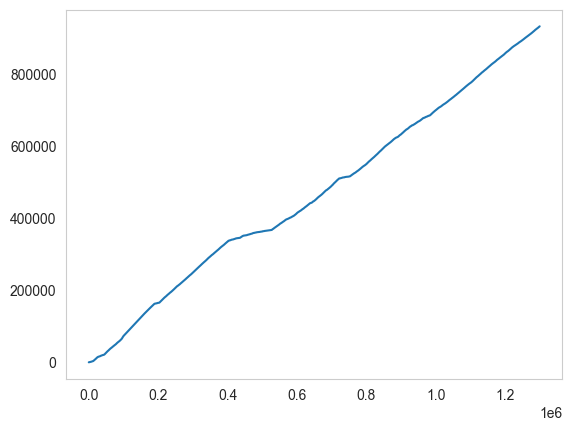

In [50]:
# Compute cumsum of size/volumes
cumsum_size_volume = {
               'TSLA': tsla_raw_df['norm_size'].cumsum(),
               'MSFT': amzn_raw_df['norm_size'].cumsum(),
               'AMZN': nflx_raw_df['norm_size'].cumsum(),
               'NFLX': msft_raw_df['norm_size'].cumsum(),
               'EBAY': ebay_raw_df['norm_size'].cumsum(),
               'APPL': appl_raw_df['norm_size'].cumsum()
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_size_volume.items()}
tsla_cumsum_volume = amzn_raw_df['norm_size'].cumsum()
x = list(range(1, len(tsla_cumsum_volume)+1))
plt.plot(x, tsla_cumsum_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [51]:
# Standard Hurst
method = 'standard'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_std_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0023299...",82,6.0,0.021178,-5456.057330,0.944720,0.999648,0.771331,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5532761...",220,20.0,0.013058,-4830.975356,0.369137,0.999893,0.879958,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4596022...",1,1.0,0.020439,-8639.504901,1.930452,0.998213,0.616621,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4744909...",844,40.0,0.016988,-4930.084271,0.251712,0.999829,0.846644,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4137142...",469,34.0,0.016026,-3769.927265,0.255688,0.999864,0.835960,EBAY,volume


In [52]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7637149921368803


In [53]:
display(volume_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'volume'), ('MSFT', 'standard', 'volume'), ('AMZN', 'standard', 'volume'), ('NFLX', 'standard', 'volume'), ('EBAY', 'standard', 'volume'), ('APPL', 'standard', 'volume')])

#### Generalized Hurst

In [54]:
# Generalized Hurst
method = 'generalized'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_gen_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9279089...",1,1.0,0.010678,-36395.333275,0.000058,1.0,0.999998,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7164352...",1,1.0,0.010545,-23486.957970,0.000236,1.0,0.999994,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0000006...",1,1.0,0.010372,-87885.627040,0.000007,1.0,1.000000,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.9227199...",1,1.0,0.010290,-43692.405664,0.000096,1.0,1.000003,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.0832273...",1,1.0,0.010684,-26911.597656,0.000131,1.0,1.000003,EBAY,volume


In [55]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9999927413806335
Max Generalized Hurst: 1.0000034468052998
Average Generalized Hurst: 0.9999986836009604
Standard_dev Generalized Hurst: 4.532798414420355e-06


In [56]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume'), ('MSFT', 'generalized', 'volume'), ('AMZN', 'generalized', 'volume'), ('NFLX', 'generalized', 'volume'), ('EBAY', 'generalized', 'volume'), ('APPL', 'generalized', 'volume')])


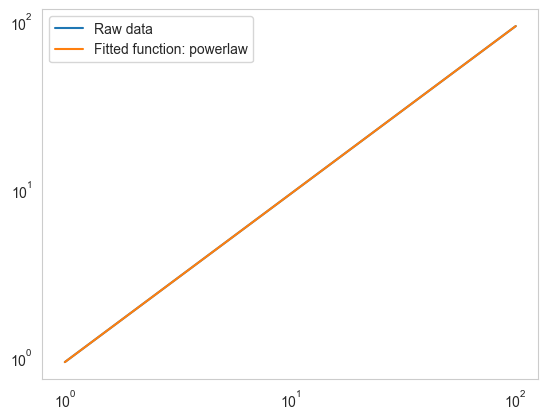

In [57]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volume_fit_objects[('TSLA', 'generalized', 'volume')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Signed Ordeflow Imbalance

In [58]:
# Aggregate orderflow
tsla_aggregate_orderflow = add_aggregate_features(tsla_raw_df, [LAG], remove_outliers=False)
msft_aggregate_orderflow = add_aggregate_features(msft_raw_df, [LAG], remove_outliers=False)
amzn_aggregate_orderflow = add_aggregate_features(amzn_raw_df, [LAG], remove_outliers=False)
nflx_aggregate_orderflow = add_aggregate_features(nflx_raw_df, [LAG], remove_outliers=False)
ebay_aggregate_orderflow = add_aggregate_features(ebay_raw_df, [LAG], remove_outliers=False)
appl_aggregate_orderflow = add_aggregate_features(appl_raw_df, [LAG], remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

#### Stationarity Test

In [59]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -15.38
p-value: 0.00,
N: 25357, 
critical values: {'1%': -3.4306079154517635, '5%': -2.861653990891583, '10%': -2.5668306740063134}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -28.80
p-value: 0.00,
N: 45743, 
critical values: {'1%': -3.4304929654154996, '5%': -2.861603187647941, '10%': -2.5668036327177557}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -12.12
p-value: 0.00,
N: 12960, 
critical values: {'1%': -3.430854675593285, '5%': -2.861763042201846, '10%': -2.5668887204277646}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -23.93
p-value: 0.00,
N: 107484, 
critical values: {'1%': -3.430410841205937, '5%': -2.8615668908804603, '10%': -2.5667843130711}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

In [60]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -16.09
p-value: 0.00,
N: 25360, 
critical values: {'1%': -3.4306078849381714, '5%': -2.8616539774060765, '10%': -2.566830666828272}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -22.48
p-value: 0.00,
N: 45724, 
critical values: {'1%': -3.430493024826212, '5%': -2.861603213905569, '10%': -2.5668036466939426}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -15.64
p-value: 0.00,
N: 12969, 
critical values: {'1%': -3.4308543252979784, '5%': -2.861762887401409, '10%': -2.566888638028639}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -24.92
p-value: 0.00,
N: 107484, 
critical values: {'1%': -3.430410841205937, '5%': -2.8615668908804603, '10%': -2.5667843130711}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
ADF

### 3.1. Order sign imbalance long memory

In [61]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/lo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [62]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/lo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


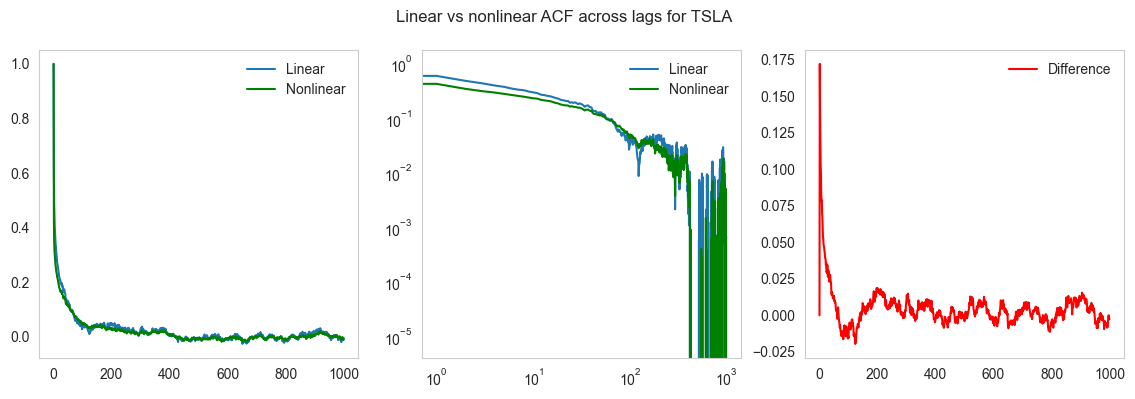

TSLA Max difference: 0.1721116822187161


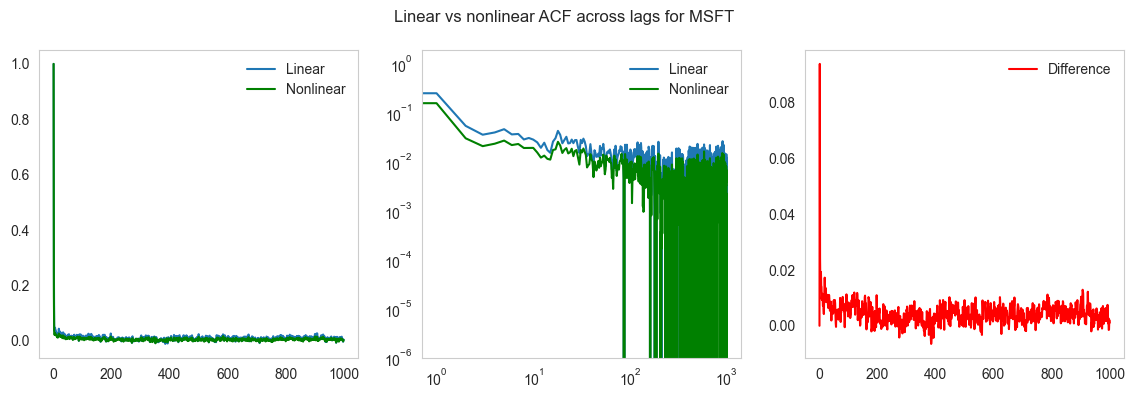

MSFT Max difference: 0.09394487122892106


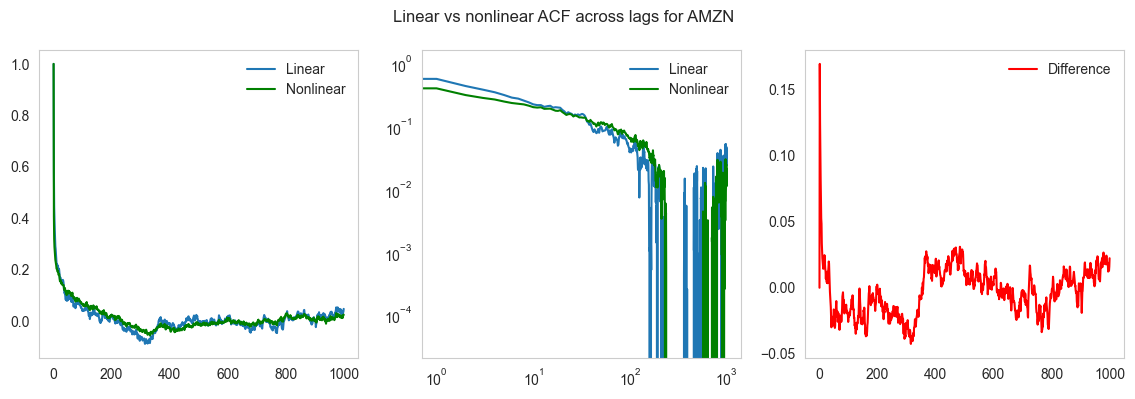

AMZN Max difference: 0.16924954777035256


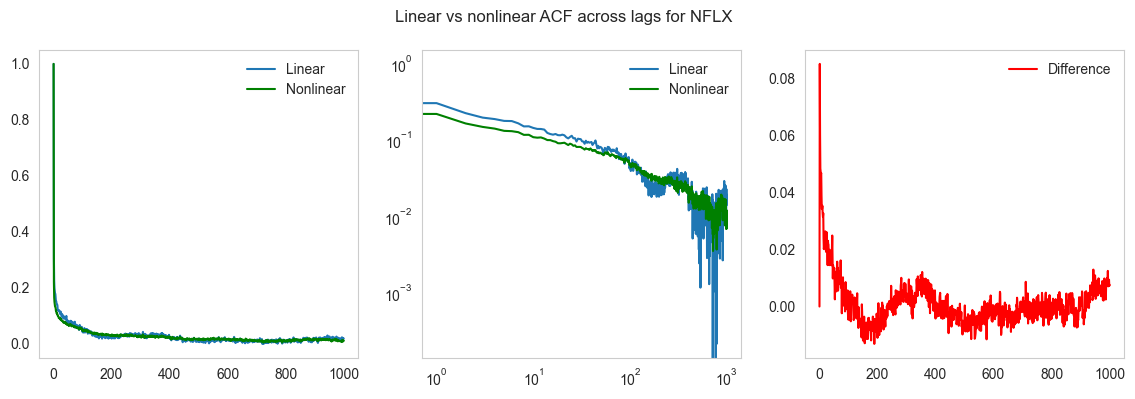

NFLX Max difference: 0.0851174239524245


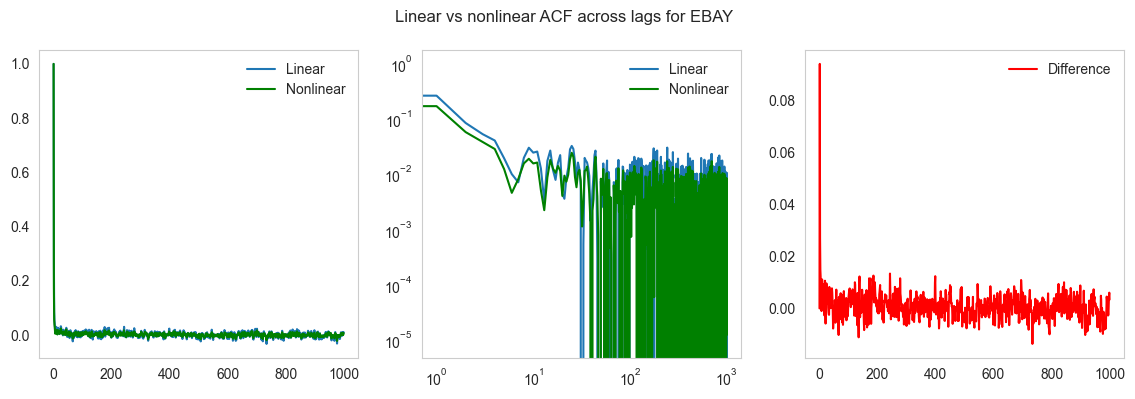

EBAY Max difference: 0.09408565592545853


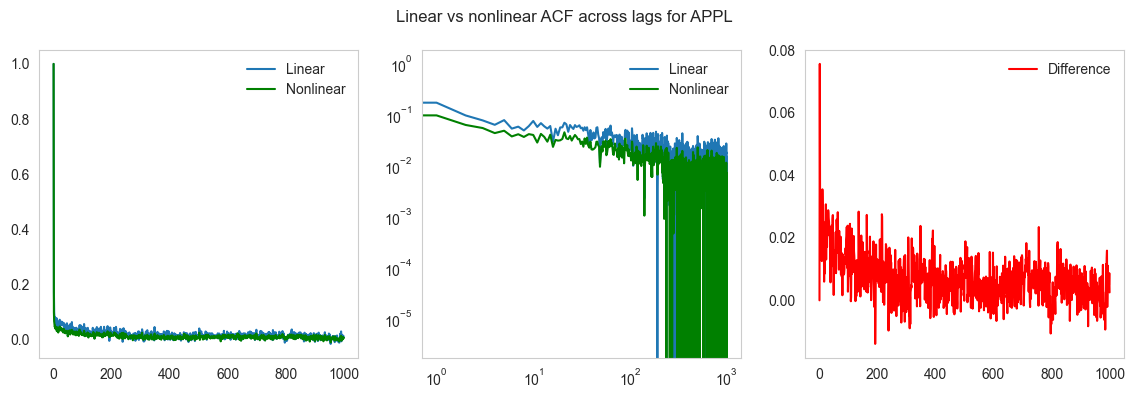

APPL Max difference: 0.07557204317977266


In [63]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 3.1.1. Fit power law to ACF

In [64]:
# Load the pre-computed ACFs
sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [65]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.9685195...",10,11.0,0.549950,-8448.072479,312.912935,0.861175,-0.922687,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0496473...",10,11.0,0.358224,-10965.368710,453.530814,0.214965,-0.415737,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.5818697...",10,11.0,0.563068,-7215.934033,159.409765,0.618108,-1.007508,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.4846673...",10,11.0,0.248234,-10767.015328,20.237158,0.939948,-0.524274,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1210222...",10,11.0,0.460141,-10219.578882,167.537337,0.108204,-0.808940,EBAY


In [66]:
print(sign_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [67]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6987158364909355


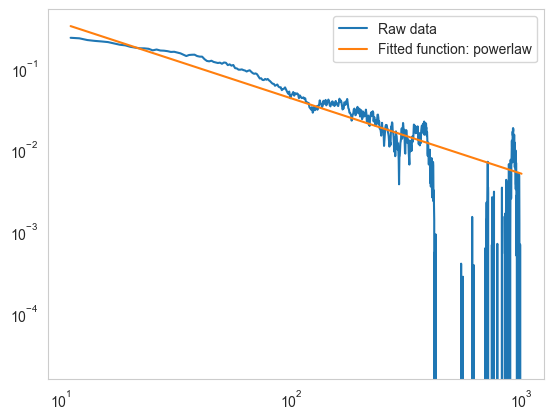

In [68]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.1.2. Sign Imbalance Hurst Exponents

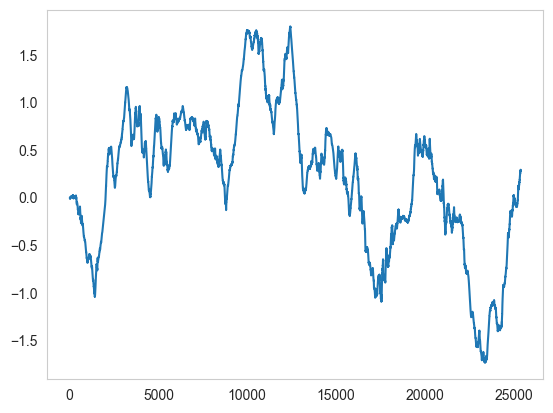

In [69]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_sign_imbalance.items()}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [70]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0039067...",1,1.0,0.031646,-2088.196700,2.054212,0.999038,0.796837,TSLA,sign_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003121...",1,1.0,0.023585,-4042.092306,1.962957,0.998545,0.679604,MSFT,sign_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0039425...",1,1.0,0.035714,-1423.131912,2.275957,0.998141,0.777531,AMZN,sign_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005917...",1,1.0,0.021472,-5898.370292,0.930687,0.999717,0.813559,NFLX,sign_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0009912...",1,1.0,0.035971,-2305.266493,1.688986,0.996464,0.606631,EBAY,sign_imbalance


In [71]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6142892143114855


##### Generalized Hurst

In [72]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029031...",1,1.0,0.018987,-2375.677216,1.507705,0.999765,0.815478,TSLA,signed_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002301...",1,1.0,0.018868,-4429.208656,1.565837,0.999515,0.668252,MSFT,signed_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0025448...",1,1.0,0.017857,-1923.672405,0.452985,0.999967,0.823147,AMZN,signed_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004171...",1,1.0,0.012270,-6877.355534,0.669842,0.999975,0.825121,NFLX,signed_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0006845...",1,1.0,0.014388,-2735.591724,1.042214,0.999717,0.623841,EBAY,signed_imbalance


In [73]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.00838218452418879
Max Generalized Hurst: 0.8251209890458221
Average Generalized Hurst: 0.6273700751909501
Standard_dev Generalized Hurst: 0.31548322229600667


In [74]:
print(sign_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_imbalance'), ('MSFT', 'generalized', 'signed_imbalance'), ('AMZN', 'generalized', 'signed_imbalance'), ('NFLX', 'generalized', 'signed_imbalance'), ('EBAY', 'generalized', 'signed_imbalance'), ('APPL', 'generalized', 'signed_imbalance')])


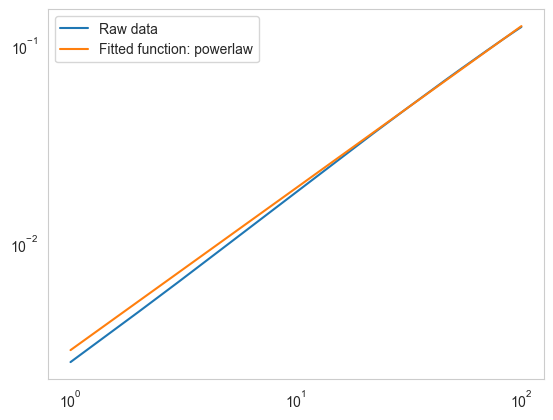

In [75]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()

### 3.2. Signed Volume imbalance long memory

In [76]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/lo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [77]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/lo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


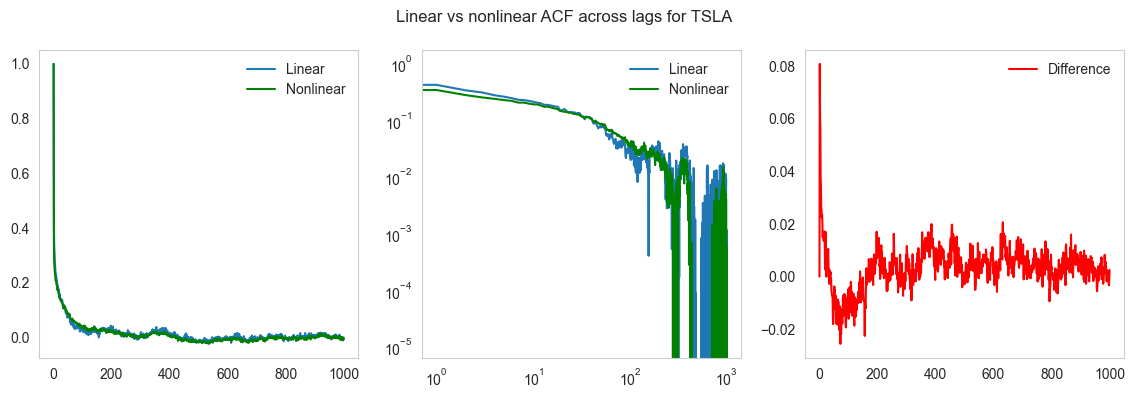

TSLA Max difference: 0.08076847718302149


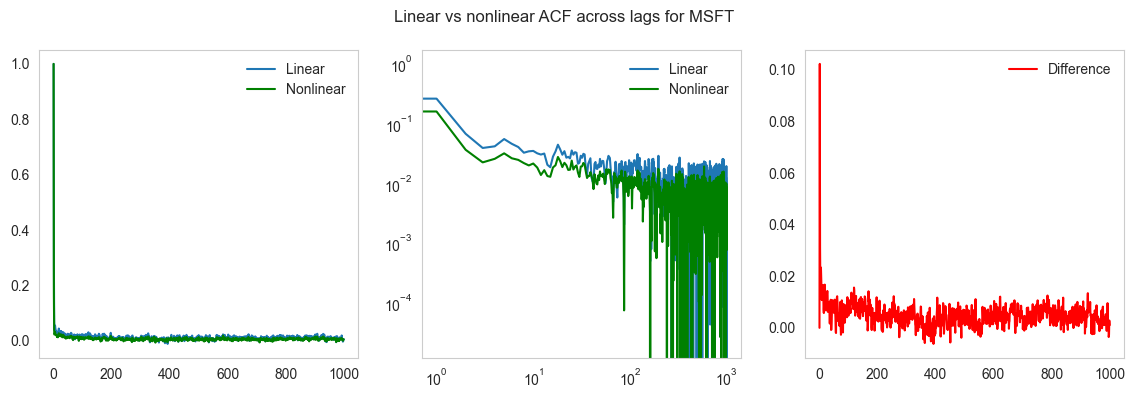

MSFT Max difference: 0.10232552486557067


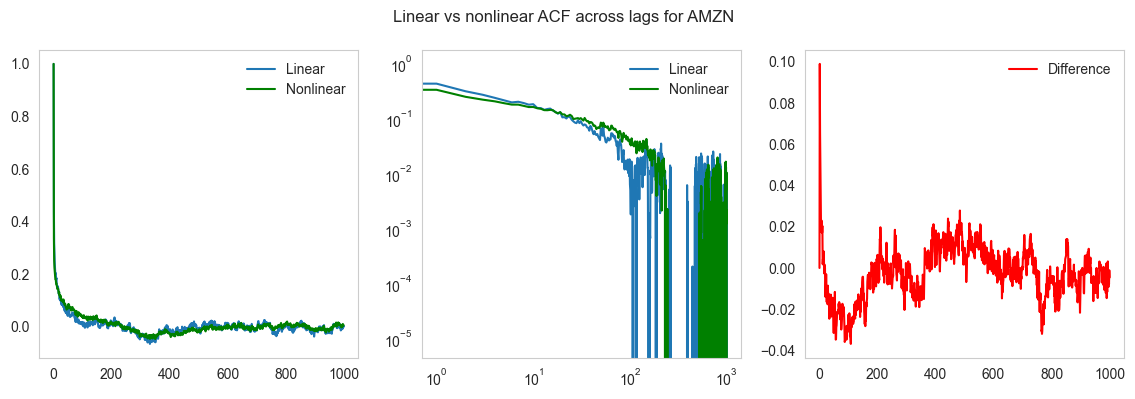

AMZN Max difference: 0.09902653179289095


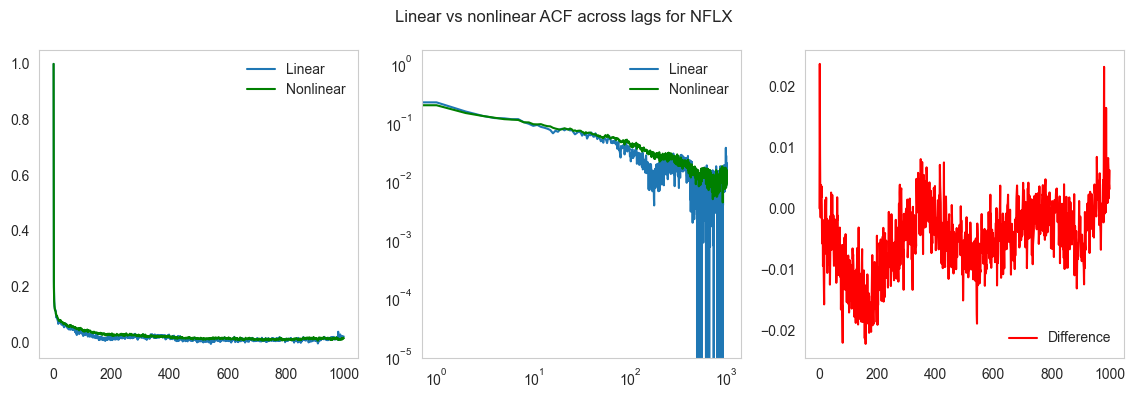

NFLX Max difference: 0.023660623971932915


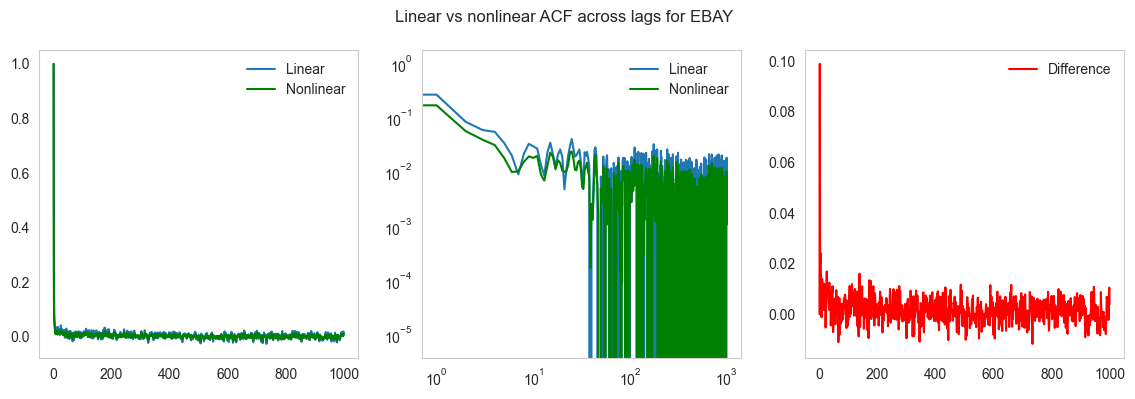

EBAY Max difference: 0.09892231789014536


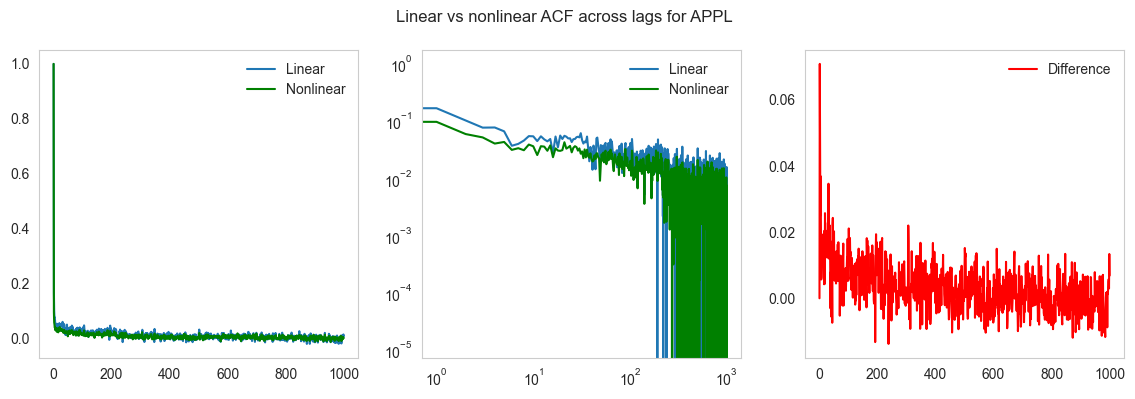

APPL Max difference: 0.07088638435549441


In [78]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 3.2.1. Fit power law to ACF

In [79]:
# Load the pre-computed ACFs
volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [80]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.8379345...",10,11.0,0.568113,-8623.197304,296.197436,0.830254,-0.979475,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0449067...",10,11.0,0.337033,-11030.402763,218.541583,0.265803,-0.327792,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.2751243...",10,11.0,0.588295,-7818.219623,182.367578,0.602604,-1.093320,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.4145522...",10,11.0,0.252270,-10957.152394,20.396449,0.933537,-0.522378,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1499830...",10,11.0,0.453078,-10211.956340,231.634048,0.170991,-0.793264,EBAY


In [81]:
print(volume_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [82]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.706258543835021


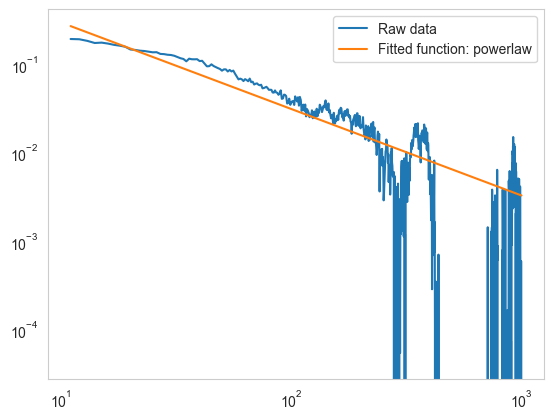

In [83]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.2.2. Volume Imbalance Hurst Exponents

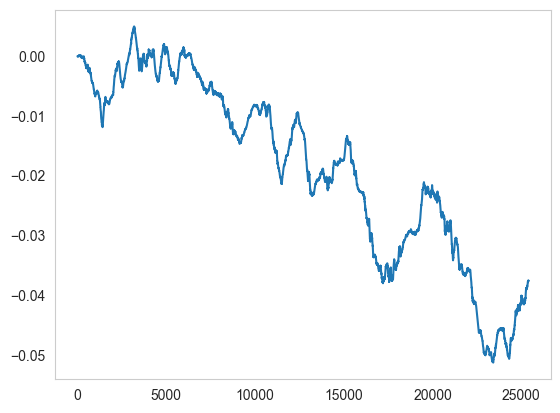

In [84]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['vol_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'].cumsum(),
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_volume_imbalance.items()}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['vol_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [85]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.9379519...",1,1.0,0.031646,-3547.922360,1.930520,0.998915,0.780231,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.5998017...",1,1.0,0.033019,-5889.328461,2.049575,0.998468,0.695409,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.0440193...",1,1.0,0.035714,-2460.777762,2.492883,0.997612,0.741565,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.1015086...",1,1.0,0.021472,-8833.404483,1.446684,0.999582,0.789192,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1208779...",1,1.0,0.028777,-3562.843941,1.456363,0.997325,0.625642,EBAY,volume_imbalance


In [86]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6058467342756984


##### Generalized Hurst

In [87]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.8138865...",1,1.0,0.018987,-3825.922404,1.440751,0.999704,0.801656,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.5191076...",1,1.0,0.014151,-6362.153009,1.473363,0.999672,0.697870,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.6024762...",1,1.0,0.017857,-2915.324889,0.778445,0.999936,0.787433,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.1713137...",1,1.0,0.012270,-9828.112893,0.752337,0.999964,0.804166,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 7.3200694...",1,1.0,0.014388,-3927.097616,1.264699,0.999674,0.659175,EBAY,volume_imbalance


In [88]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.0076760947518680935
Max Generalized Hurst: 0.8041664967618459
Average Generalized Hurst: 0.6263294021054912
Standard_dev Generalized Hurst: 0.30894941199786397


In [89]:
display(volume_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume_imbalance'), ('MSFT', 'generalized', 'volume_imbalance'), ('AMZN', 'generalized', 'volume_imbalance'), ('NFLX', 'generalized', 'volume_imbalance'), ('EBAY', 'generalized', 'volume_imbalance'), ('APPL', 'generalized', 'volume_imbalance')])

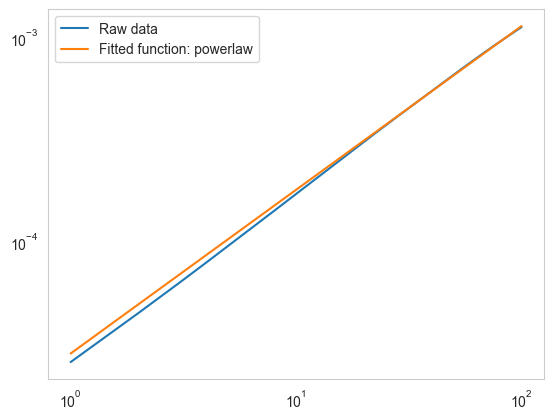

In [90]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()